In [1]:
import normflows as nf
from normflows import flows
## Standard libraries
import os
import math
import time

import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim

import dgl #NOTE: for dgl.batch and dgl.unbatch
from dgl import save_graphs, load_graphs
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.data.utils import save_info, load_info, Subset

import umap
reducer = umap.UMAP();
from tqdm import tqdm

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import scipy.optimize as opt
from scipy.stats import crystalball

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/v

Using device cuda:0


In [2]:
#custom imports
from utils import load_graph_dataset, train, evaluate, GraphDataset, get_graph_dataset_info
from models import GIN, HeteroGIN
from NF_utils import Latent_data, get_masked_affine, transform, train,plot_loss, test,plot_9_histos, plot_UMAP_sidebyside,plot_UMAP_overlay, create_latent_data, NFClassifier,train_classifier,test_classifier_MC,test_classifier_data,plot_classified


Using device cuda:0


In [3]:
'''                                              '''
'''     SETTING UP LATENT SPACE REPRESENTATION   '''
'''                                              '''

#Number of graphs in each
# DATA_max_events = 149090
DATA_max_events = 249090
MC_max_events = 141118

# Data and MC both have the same prefix
prefix = "/hpc/group/vossenlab/mfm45/.dgl/"

# MC inside Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
MCdataset = "Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

# Data inside data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
DATAdataset = "data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

max_events = 1e5
split = 0.1
nlayers = 2
nmlp = 3
hdim = 64
nclasses, nfeatures, nfeatures_edge = get_graph_dataset_info(dataset=MCdataset, prefix=prefix)
dropout = 0.8
learn_eps = False
batch = 256
indices = None
nworkers = 0
npooling = "max"
gpooling = "max"
torch.manual_seed(0)

#select model
extractor = GIN(nlayers, nmlp, nfeatures,
            hdim, nclasses, dropout, learn_eps, npooling, gpooling).to(device)
extractor.load_state_dict(torch.load("logs/model_weights",map_location=device))
#select training data

<All keys matched successfully>

In [4]:
num_samples = 100
training_data_DATA = create_latent_data(DATAdataset, extractor,num_samples = num_samples, max_events = DATA_max_events)
training_data_MC = create_latent_data(MCdataset, extractor,num_samples = num_samples, max_events = MC_max_events)

testing_data_DATA = create_latent_data(DATAdataset, extractor, mode = "test",num_samples = num_samples, max_events = DATA_max_events)
testing_data_MC = create_latent_data(MCdataset, extractor, mode = "test",num_samples = num_samples, max_events = MC_max_events)

val_data_DATA = create_latent_data(DATAdataset, extractor, mode = "val",num_samples = num_samples, max_events = DATA_max_events)
val_data_MC = create_latent_data(MCdataset, extractor, mode = "val",num_samples = num_samples, max_events = MC_max_events)

No mode given, defaulting to training



/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


No mode given, defaulting to training



In [13]:
class Latent_data:
    def __init__(self, in_tensor,labels, sidebands = False):
        self.data = in_tensor
        self.labels = labels
        self.num_events = in_tensor.size()[0]
        self.latent_size = in_tensor.size()[1]
    def get_sidebands(self, cut = 1.14):
        for i in range(len(self.data)):
            if(self.mass[i] < 1.14):
                self.data[i] = (9999 * torch.ones_like(self.data[i]))
                self.labels[i] = (9999 * torch.ones_like(self.labels[i]))
                self.mass[i] = (9999 * torch.ones_like(self.mass[i]))
        self.data = self.data[self.data[:,0] != 9999]
        self.labels = self.labels[self.labels[:,0] != 9999]
        self.mass = self.mass[self.mass[:] != 9999]
        self.num_events = self.data.size()[0]
    def set_batch_size(self,batch_size):
        self.batch_size = batch_size
        self.max_iter = int(self.num_events / self.batch_size)
    def set_mass(self, mass):
        self.mass = mass
    def sample(self,iteration = 0, random = False, _give_labels = False):
        if(random):
            return self.sample_random(give_labels = _give_labels)
        else:
            return self.sample_fixed(iteration,give_labels = _give_labels)
    def sample_fixed(self,iteration,give_labels = False):
        #0 index iterations - the "first" iteration is with iteration = 0
        # Calculate the first index we want to take from training data (rest of data is directly after)
        begin = iteration * self.batch_size
        # initialize
        samples = torch.zeros(self.batch_size, self.latent_size)
        labels = torch.zeros(self.batch_size, 1)
#         print(f"labels max (inside sample_fixed): {labels.max()}")
        #loop over consecutive tensors, save to return tensor
        if(give_labels):
            for i in range(self.batch_size):
                samples[i] = self.data[begin + i]
                labels[i] = self.labels[begin+i]
            return samples,labels
        else:
            for i in range(self.batch_size):
                samples[i] = self.data[begin + i]
            return samples
    def sample_random(self,labels = False):
        indices = rng.integers(low=0, high=self.num_events, size=self.batch_size)
        samples = torch.zeros(self.batch_size,self.latent_size)
        for index in range(len(indices)):
            samples[index] = self.data[indices[index]]
        return samples


In [14]:
sb_training_DATA = Latent_data(torch.clone(training_data_DATA.data), torch.clone(training_data_DATA.labels), sidebands = True)
sb_training_DATA.set_mass(torch.clone(training_data_DATA.mass))
sb_training_DATA.get_sidebands()
sb_training_DATA.set_batch_size(100)

sb_training_MC = Latent_data(torch.clone(training_data_MC.data), torch.clone(training_data_MC.labels), sidebands = True)
sb_training_MC.set_mass(torch.clone(training_data_MC.mass))
sb_training_MC.get_sidebands()
sb_training_MC.set_batch_size(100)


sb_testing_DATA = Latent_data(torch.clone(testing_data_DATA.data), torch.clone(testing_data_DATA.labels), sidebands = True)
sb_testing_DATA.set_mass(torch.clone(testing_data_DATA.mass))
sb_testing_DATA.get_sidebands()
sb_testing_DATA.set_batch_size(100)

sb_testing_MC = Latent_data(torch.clone(testing_data_MC.data), torch.clone(testing_data_MC.labels), sidebands = True)
sb_testing_MC.set_mass(torch.clone(testing_data_MC.mass))
sb_testing_MC.get_sidebands()
sb_testing_MC.set_batch_size(100)

sb_val_DATA = Latent_data(torch.clone(val_data_DATA.data), torch.clone(val_data_DATA.labels), sidebands = True)
sb_val_DATA.set_mass(torch.clone(val_data_DATA.mass))
sb_val_DATA.get_sidebands()
sb_val_DATA.set_batch_size(100)

sb_val_MC = Latent_data(torch.clone(val_data_MC.data), torch.clone(val_data_MC.labels), sidebands = True)
sb_val_MC.set_mass(torch.clone(val_data_MC.mass))
sb_val_MC.get_sidebands()
sb_val_MC.set_batch_size(100)


In [26]:
# SETTING UP DATA MODEL

masked_affine_flows_train_DATA = get_masked_affine(40)
distribution_DATA = nf.distributions.DiagGaussian(training_data_DATA.latent_size, trainable = False)
masked_affine_model_DATA = nf.NormalizingFlow(q0=distribution_DATA, flows=masked_affine_flows_train_DATA)
DATA_model = masked_affine_model_DATA.to(device)

# SETTING UP MC MODEL

masked_affine_flows_train_MC = get_masked_affine(40)
distribution_MC = nf.distributions.DiagGaussian(training_data_MC.latent_size, trainable = False)
masked_affine_model_MC = nf.NormalizingFlow(q0=distribution_MC, flows=masked_affine_flows_train_MC)
MC_model = masked_affine_model_MC.to(device)

  0%|          | 0/671 [01:06<?, ?it/s]


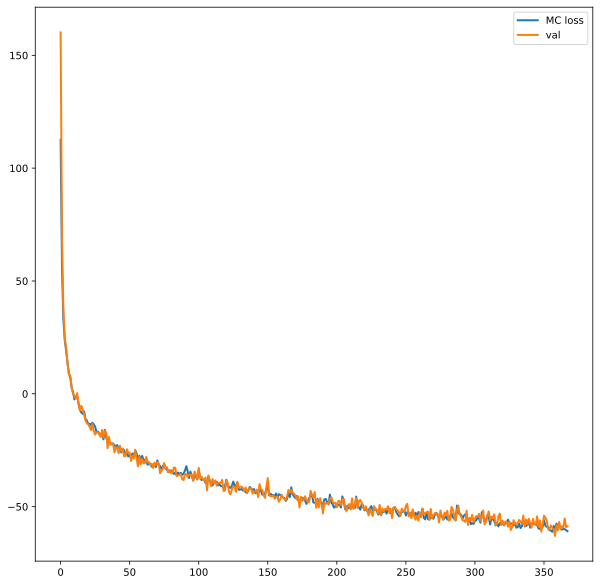

Lowest Loss: -61.098077583312985


In [27]:
# TRAINING MC
loss_hist_MC, val_hist_MC, full_loss_hist_MC, full_val_hist_MC = train(sb_training_MC, MC_model, val = True, val_data = sb_val_MC, num_epochs = 11, compact_num = 20)
plot_loss(loss_hist_MC, label = "MC loss",plot_val = True, val_loss_hist = val_hist_MC)

In [28]:
# masked_affine_flows_train_MC = get_masked_affine(52)
# distribution_MC = nf.distributions.DiagGaussian(training_data_MC.latent_size, trainable = False)
# masked_affine_model_MC = nf.NormalizingFlow(q0=distribution_MC, flows=masked_affine_flows_train_MC)
# masked_affine_model_MC.load("models/NF_MC/MC_july_4.pth")
# MC_model = masked_affine_model_MC.to(device)

In [29]:
# Testing MC
test(sb_testing_MC, MC_model, data_type = "MC")

100%|██████████| 83/83 [00:01<00:00, 54.21it/s]

MC average loss: -57.22000503540039


In [30]:
# MC_model.save("models/NF_MC/MC_sidebands_july_10.pth")

In [31]:
# masked_affine_flows_train_DATA = get_masked_affine(52)
# distribution_DATA = nf.distributions.DiagGaussian(training_data_DATA.latent_size, trainable = False)
# masked_affine_model_DATA = nf.NormalizingFlow(q0=distribution_DATA, flows=masked_affine_flows_train_DATA)
# masked_affine_model_DATA.load("models/NF_DATA/DATA_july_4.pth")
# DATA_model = masked_affine_model_DATA.to(device)

  0%|          | 0/1565 [02:31<?, ?it/s]


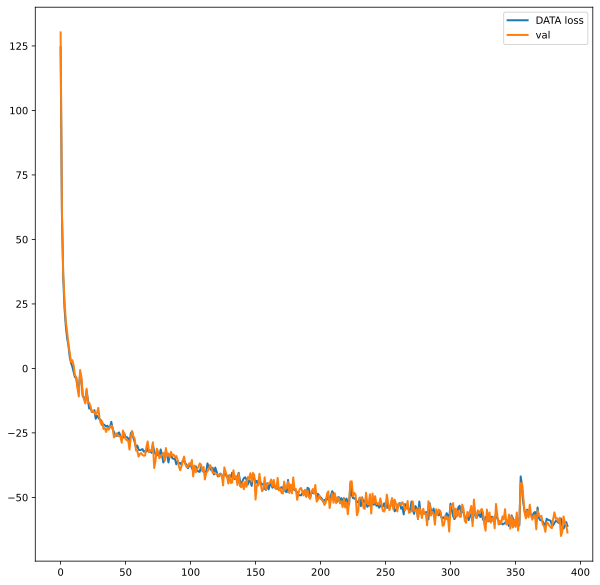

Lowest Loss: -62.09566783905029


In [32]:
# TRAINING DATA
loss_hist_DATA, val_hist_DATA, full_loss_hist_DATA, full_val_hist_DATA = train(sb_training_DATA, DATA_model, val = True, val_data = sb_val_DATA, num_epochs = 5, compact_num = 20)
plot_loss(loss_hist_DATA, label = "DATA loss", plot_val = True, val_loss_hist = val_hist_DATA)

In [33]:
# DATA_model.save("models/NF_DATA/DATA_sidebands_july_10.pth")

In [34]:

# Testing DATA
test(sb_testing_DATA, DATA_model, data_type = "DATA")

100%|██████████| 195/195 [00:03<00:00, 60.86it/s]

DATA average loss: -61.534034729003906


In [35]:
transformed_latent_MC = transform(testing_data_MC, MC_model)
transformed_latent_DATA = transform(testing_data_DATA, DATA_model)

100%|██████████| 249/249 [00:04<00:00, 58.62it/s]


In [36]:
transformed_latent_train_MC = transform(training_data_MC, MC_model)
transformed_latent_train_DATA = transform(training_data_DATA, DATA_model)
transformed_latent_val_MC = transform(val_data_MC, MC_model)
transformed_latent_val_DATA = transform(val_data_DATA, DATA_model)

100%|██████████| 249/249 [00:04<00:00, 55.87it/s]


In [37]:
# From above plotting: <transformed_latent_DATA> is the tensor with normalized DATA
# Now need to transform it back to MC version of latent space
transformed_latent_DATA_obj = Latent_data(transformed_latent_DATA,testing_data_DATA.labels)
transformed_latent_DATA_obj.set_batch_size(num_samples)
transformed_latent_MC_obj = Latent_data(transformed_latent_MC,testing_data_MC.labels)
transformed_latent_MC_obj.set_batch_size(num_samples)

In [38]:
transformed_latent_train_DATA_obj = Latent_data(transformed_latent_train_DATA,training_data_DATA.labels)
transformed_latent_train_DATA_obj.set_batch_size(num_samples)
transformed_latent_train_MC_obj = Latent_data(transformed_latent_train_MC,training_data_MC.labels)
transformed_latent_train_MC_obj.set_batch_size(num_samples)

In [39]:
transformed_latent_val_DATA_obj = Latent_data(transformed_latent_val_DATA,val_data_DATA.labels)
transformed_latent_val_MC_obj = Latent_data(transformed_latent_val_MC,val_data_MC.labels)

In [40]:
full_pass_DATA = transform(transformed_latent_DATA_obj, MC_model, reverse = False)
full_pass_DATA_obj = Latent_data(full_pass_DATA, testing_data_DATA.labels)
full_pass_DATA_obj.set_batch_size(num_samples)

100%|██████████| 249/249 [00:04<00:00, 56.75it/s]


In [41]:
full_pass_train_DATA = transform(transformed_latent_train_DATA_obj, MC_model, reverse = False)
full_pass_train_DATA_obj = Latent_data(full_pass_train_DATA, training_data_DATA.labels)
full_pass_train_DATA_obj.set_batch_size(num_samples)

100%|██████████| 1992/1992 [00:34<00:00, 58.31it/s]


## Prediction

In [42]:
classifier = NFClassifier(num_layers = 10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4, weight_decay=1e-5)
num_epochs_classifier = 15

  0%|          | 0/1128 [00:08<?, ?it/s]


Finished Training


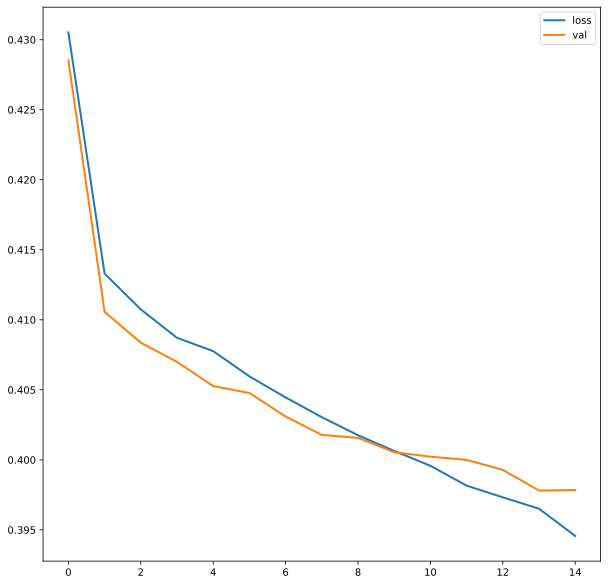

Lowest Loss: 0.3945652019787342


In [43]:
loss_hist, val_loss_hist = train_classifier(training_data_MC, classifier, criterion, optimizer, val = True, val_data = val_data_MC, num_epochs = num_epochs_classifier)

plot_loss(loss_hist, plot_val =True, val_loss_hist = val_loss_hist)

In [44]:
test_classifier_MC(testing_data_MC,classifier)

  0%|          | 0/141 [00:00<?, ?it/s]


Accuracy: 81.82397959183673


In [45]:
def test_classifier_data_DEBUG(test_data, classifier):
    outputs_data = torch.empty(test_data.num_events,2)
    #Converting normalized DATA to classifier output
    with tqdm(total=test_data.max_iter, position=0, leave=True) as pbar:
        for it in tqdm(range(test_data.max_iter), position = 0, leave=True):
            #randomly sample the latent space
            samples, labels = test_data.sample(iteration = it, _give_labels = True)
            samples = samples.to(device)
            # forward + backward + optimize
            output_batch = classifier(samples)
            for i in range(test_data.batch_size):
                outputs_data[it*test_data.batch_size + i] = output_batch[i]
    probs_data = torch.softmax(outputs_data, 1)
    return probs_data

In [46]:
probs_DATA_test = test_classifier_data_DEBUG(full_pass_DATA_obj, classifier)
probs_DATA_fp = test_classifier_data_DEBUG(full_pass_train_DATA_obj, classifier)
probs_DATA = test_classifier_data_DEBUG(training_data_DATA, classifier)
probs_MC = test_classifier_data_DEBUG(training_data_MC, classifier)

  0%|          | 0/1128 [00:04<?, ?it/s]


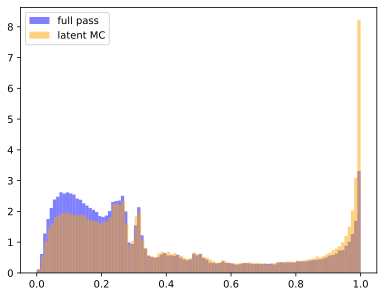

In [53]:
plt.hist(probs_DATA_fp[:,1].detach().to("cpu"),color = "blue", alpha = 0.5, bins = 100,density = True, label = "full pass");
plt.hist(probs_MC[:,1].detach().to("cpu"), color = "orange", alpha = 0.5, bins = 100,density = True, label = "latent MC");
plt.legend()
plt.show()

In [57]:
cut_hist = torch.empty(10,3)
for i in range(10):
    roc_cut = i / 10
    probs_data = probs_DATA_fp
    if(roc_cut == 0):
        argmax_Y = torch.max(probs_data, 1)[1]
    else:
        argmax_Y = torch.tensor([1 if el>roc_cut else 0 for el in probs_data[:,1]],dtype=torch.long)

    masked_mass = argmax_Y * training_data_DATA.mass
    #     signal_mass = argmax_Y * testing_data_DATA.mass
    signal_mass = np.array([])
    for j in range(masked_mass.size()[0]):
        if(masked_mass[j] != 0):
            signal_mass = np.append(signal_mass, masked_mass[j])
    # Define fit function


    low_high = (1.08,1.24)
    bins = 100

    hdata = np.histogram(signal_mass, range=low_high, bins=bins, density=False);
#     hdata = plt.hist(signal_mass, color='tab:orange', alpha=0.5, range=low_high, bins=bins, histtype='stepfilled', density=False, label='signal');

    N, beta, m, loc, scale, A, B, C = 10, 1, 1.112, 1.115, 0.008, np.average(hdata[0][-10:-1]), 37, 1.24
    d_N, d_beta, d_m, d_loc, d_scale, d_A, d_B, d_C = N/0.01, beta/0.1, m/0.1, loc/0.1, scale/0.01, A/10, B/0.1, C/1
    parsMin = [N-d_N, beta-d_beta, m-d_m, loc-d_loc, scale-d_scale, B-d_B]
    parsMax = [N+d_N, beta+d_beta, m+d_m, loc+d_loc, scale+d_scale, B+d_B]

    def func(x, N, beta, m, loc, scale, B, A=A, C=C):
        return N*crystalball.pdf(-x, beta, m, -loc, scale) + A*(1 - B*(x - C)**2)

    def sig(x, N, beta, m, loc, scale):
        return N*crystalball.pdf(-x, beta, m, -loc, scale)

    def bg(x, B, A=A, C=C):
        return A*(1 - B*(x - C)**2)

    optParams, pcov = opt.curve_fit(func, hdata[1][:-1], hdata[0], method='trf', bounds=(parsMin,parsMax))

    x = np.linspace(low_high[0],low_high[1],bins)
    y = hdata[0]

#     plt.plot(x, func(x, *optParams), color='r')
#     plt.plot(x, sig(x, *optParams[0:5]), color='tab:purple')
#     plt.plot(x, bg(x, *optParams[5:]), color='b')

    bghist = np.histogram(x, weights=y-bg(x, *optParams[5:]), bins=bins, range=low_high);
#     bghist = plt.hist(x, weights=y-bg(x, *optParams[5:]), bins=bins, range=low_high, histtype='step', alpha=0.5, color='b');
    # plt.savefig("plots/bghist_0_07_diff.jpeg")

    r = np.divide(y - func(x, *optParams),np.sqrt([el if el>0 else 1 for el in func(x, *optParams)]))
    chi2 = np.sum(np.square(r))
    chi2ndf = chi2/len(optParams)

    # Get S and N before and after? #DEBUGGING: ADDED
    import scipy.integrate as integrate
    mu      = optParams[3]
    sigma   = optParams[4]
    mmin    = mu - 2*sigma
    mmax    = mu + 2*sigma


    binwidth = (low_high[1]-low_high[0])/bins#KEEP!!!

    bin1 = int((mmin-low_high[0])/binwidth)
    bin2 = int((mmax-low_high[0])/binwidth)

    integral_bghist = sum(bghist[0][bin1:bin2])

    integral_tothist = sum(hdata[0][bin1:bin2])
    # try:
    fom = integral_bghist/np.sqrt(integral_tothist)
    purity =(integral_bghist)/integral_tothist
    cut_hist[i] = torch.tensor([roc_cut, fom, purity])
    # except Exception as inst:
    #     print(f"Caught {inst} | skipping cut #{i} = {roc_cut}")
#     print(f"roc_cut = {roc_cut} | FOM: {fom} | purity: {purity}")


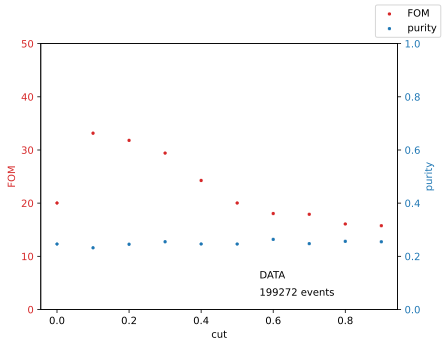

In [59]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('cut')
ax1.scatter(cut_hist[:,0], cut_hist[:,1], label = "FOM", color = "tab:red",marker = '+', s = 10)
ax1.set_ylabel('FOM', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0, 50])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('purity', color=color)  # we already handled the x-label with ax1
ax2.scatter(cut_hist[:,0], cut_hist[:,2], label = "purity", color = "tab:blue",marker = '+',s = 10)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 1])
fig.legend()
fig.text(0.6,0.2,"DATA")
fig.text(0.6,0.15,f"{len(probs_data)} events")
# fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
# fig.savefig("plots/FOMpure/DATA_fp.jpeg")

In [60]:
probs_data.size()

torch.Size([199272, 2])